In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn as sk
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
Data = pd.read_csv('GOOGL.csv')
Data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602
5,2004-08-26,52.527527,54.029030,52.382381,54.009010,54.009010,7094898
6,2004-08-27,54.104103,54.364365,52.897900,53.128128,53.128128,6211782
7,2004-08-30,52.692692,52.797798,51.056057,51.056057,51.056057,5196798
8,2004-08-31,51.201202,51.906906,51.131130,51.236237,51.236237,4917877
9,2004-09-01,51.401402,51.536537,49.884884,50.175175,50.175175,9138253


In [3]:
Data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4426,2022-03-18,2668.489990,2724.879883,2645.169922,2722.510010,2722.510010,2223100
4427,2022-03-21,2723.270020,2741.000000,2681.850098,2722.030029,2722.030029,1341600
4428,2022-03-22,2722.030029,2821.000000,2722.030029,2797.360107,2797.360107,1774800
4429,2022-03-23,2774.050049,2791.770020,2756.699951,2765.510010,2765.510010,1257700
4430,2022-03-24,2784.000000,2832.379883,2755.010010,2831.439941,2831.439941,1317900


In [4]:
#Now that we have imported the data we need to understand some things
#1 what is our dataset saying to us 
#2 what are the  problems of our data
#3 what are the things not needed in my dataset
#4 which algorithm should i use is it supervised or unsupervised
#5 if supervised which algorithm is the best to solve my problem

In [5]:
def missing_data(Data):
    missing_data_count = Data.isnull().sum()*100 / Data.shape[0]
    Data_missing_count = pd.DataFrame(missing_data_count).round(2)
    Data_missing_count = Data_missing_count.reset_index().rename(
               columns= {
                       'index': 'Column',
                        0 : 'Missing_Percentage',
               }
)
    Data_missing_value = Data.isnull().sum()
    Data_missing_value = Data_missing_value.reset_index().rename(
                columns= {
                    'index': 'Column',
                     0: 'Missing_Count',
                }
)
    Final = Data_missing_value.merge(Data_missing_count,how = 'inner', left_on = 'Column', right_on = 'Column')  
    Final = Final.sort_values(by = 'Missing_Count', ascending = False)
    return Final

missing_data(Data)

,Column,Missing_Count,Missing_Percentage
0,Date,0,0.0
1,Open,0,0.0
2,High,0,0.0
3,Low,0,0.0
4,Close,0,0.0
5,Adj Close,0,0.0
6,Volume,0,0.0


In [6]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4431 non-null   object 
 1   Open       4431 non-null   float64
 2   High       4431 non-null   float64
 3   Low        4431 non-null   float64
 4   Close      4431 non-null   float64
 5   Adj Close  4431 non-null   float64
 6   Volume     4431 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 242.4+ KB


In [7]:
Data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4.431000e+03
mean,693.087345,699.735595,686.078751,693.097367,693.097367,6.444992e+06
std,645.118799,651.331215,638.579488,645.187806,645.187806,7.690351e+06
min,49.644646,50.920921,48.028027,50.055054,50.055054,4.656000e+05
25%,248.558563,250.853355,245.813309,248.415916,248.415916,1.695600e+06
50%,434.924927,437.887878,432.687683,435.330322,435.330322,3.778418e+06
75%,1007.364990,1020.649994,997.274994,1007.790008,1007.790008,8.002390e+06
max,3025.000000,3030.929932,2977.979980,2996.770020,2996.770020,8.215117e+07


In [8]:
len(Data)

4431

In [9]:
Data['Date'] = pd.to_datetime(Data['Date'])
Data.set_index('Date',inplace=True)

In [10]:
Data.shape

(4431, 6)

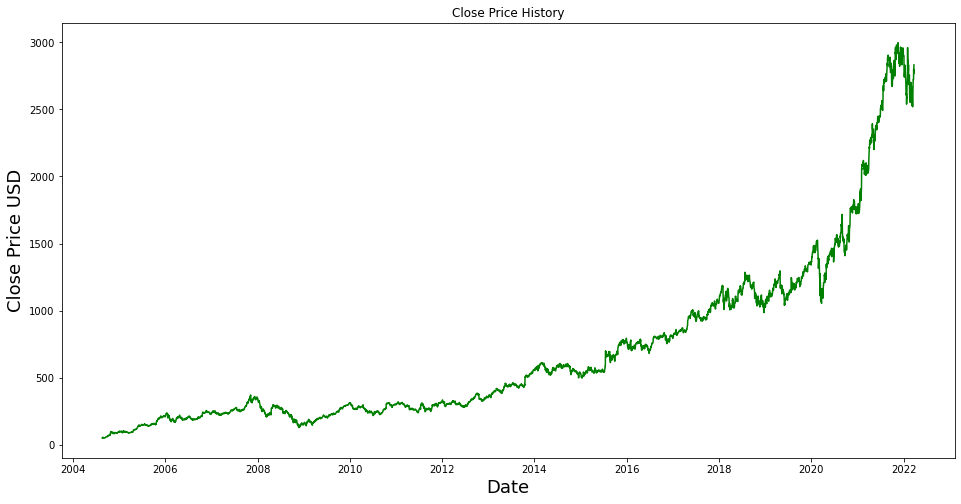

In [11]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(Data['Close'], color='green')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize = 18)
plt.show()

In [12]:
import math

In [13]:
# create a new data frame with only 'Close column'
data = Data.filter(['Close'])
dataset = data.values #convert the data frame to a numpy array
training_data_len = math.ceil(len(dataset)*.8)  # number of rows to train the model on
training_data_len

3545

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[5.60505519e-05],
       [1.40975800e-03],
       [1.59489433e-03],
       ...,
       [9.32328062e-01],
       [9.21519383e-01],
       [9.43893427e-01]])

In [15]:

train_data = scaled_data[0:training_data_len, :]
#Split the data into x_train, y_train datasets
x_train = []
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([5.60505519e-05, 1.40975800e-03, 1.59489433e-03, 8.25473121e-04,
       1.01740448e-03, 1.34181828e-03, 1.04288132e-03, 3.39701332e-04,
       4.00847389e-04, 4.07643771e-05, 2.54775575e-04, 0.00000000e+00,
       2.66664747e-04, 3.88957878e-04, 3.90656379e-04, 9.03603515e-04,
       1.27217870e-03, 1.94988184e-03, 2.03650610e-03, 2.37111091e-03,
       2.96898346e-03, 3.28660359e-03, 3.02843102e-03, 3.12015078e-03,
       3.53458550e-03, 3.36643419e-03, 3.09976910e-03, 4.56048113e-03,
       5.27725015e-03, 5.02587260e-03, 5.53202471e-03, 5.95325344e-03,
       6.51545983e-03, 6.29635313e-03, 6.59698621e-03, 6.40675573e-03,
       5.98722550e-03, 6.35070382e-03, 6.94518107e-03, 7.13201455e-03,
       7.49040041e-03, 8.34814405e-03, 8.14092652e-03, 6.87554149e-03,
       8.38551040e-03, 1.23005606e-02, 1.48432202e-02, 1.38920583e-02,
       1.46003348e-02, 1.58453385e-02, 1.53935347e-02, 1.63090287e-02,
       1.61120022e-02, 1.55684814e-02, 1.43846251e-02, 1.17774214e-02,
     

In [16]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [17]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(3485, 60, 1)

In [18]:
model =Sequential()
model.add(LSTM(64,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(64, return_sequences= False))
model.add(Dense(32))
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [20]:
#Train the model
model.fit(x_train,y_train, batch_size=1, epochs=10)

Epoch 1/10
3485/3485 [==============================] - 87s 24ms/step - loss: 1.5841e-04
Epoch 2/10
3485/3485 [==============================] - 88s 25ms/step - loss: 7.0871e-05
Epoch 3/10
3485/3485 [==============================] - 88s 25ms/step - loss: 6.0579e-05
Epoch 4/10
3485/3485 [==============================] - 88s 25ms/step - loss: 4.9272e-05
Epoch 5/10
3485/3485 [==============================] - 92s 26ms/step - loss: 3.7459e-05
Epoch 6/10
3485/3485 [==============================] - 102s 29ms/step - loss: 3.4144e-05
Epoch 7/10
3485/3485 [==============================] - 88s 25ms/step - loss: 3.9864e-05
Epoch 8/10
3485/3485 [==============================] - 93s 27ms/step - loss: 2.8869e-05
Epoch 9/10
3485/3485 [==============================] - 91s 26ms/step - loss: 2.7750e-05
Epoch 10/10
3485/3485 [==============================] - 89s 26ms/step - loss: 2.6412e-05


In [21]:
#create the testing data sets
#create a new array containing scale values from index 1543 to 2003
test_data= scaled_data[training_data_len-60:, :]
#create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [22]:
x_test = np.array(x_test)

In [23]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_test.shape

(886, 60, 1)

In [24]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

28/28 [==============================] - 2s 18ms/step


In [25]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8.956424957212011

C:\Users\1040G3~1\AppData\Local\Temp/ipykernel_15820/2566943038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions
C:\Users\1040G3~1\AppData\Local\Temp/ipykernel_15820/2566943038.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper_center'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(['Train','Valid','Predictions'], loc='upper_center')


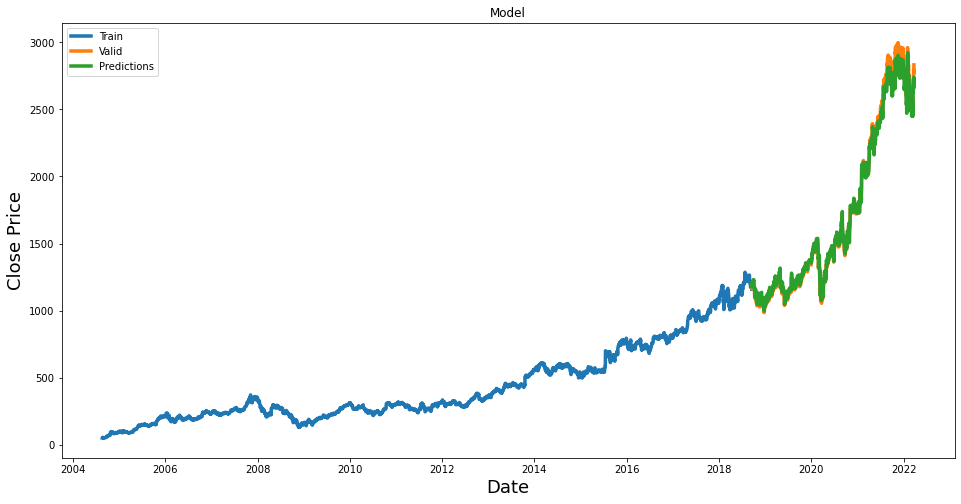

In [26]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visialization the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price' ,fontsize=18)
plt.plot(train['Close'],linewidth=3.5)
plt.plot(valid[['Close','Predictions']],linewidth=3.5)
plt.legend(['Train','Valid','Predictions'], loc='upper_center')

In [27]:
valid

,Close,Predictions
Date,,
2018-09-18,1167.109985,1177.507202
2018-09-19,1174.270020,1185.652832
2018-09-20,1191.569946,1194.704224
2018-09-21,1172.119995,1215.057861
2018-09-24,1179.560059,1191.691040
...,...,...
2022-03-18,2722.510010,2625.501953
2022-03-21,2722.030029,2669.586426
2022-03-22,2797.360107,2657.044922
